In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

## MNIST Dataset

Use the PyTorch functions to download the data.

In [ ]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)

### Visualizing the data

Number of MNIST training examples: 60000
Number of MNIST test examples: 10000

mnist train has two piece of informantion: data and targets:
    mnist train data shape: torch.Size([60000, 28, 28])
    mnist train targets shape: torch.Size([60000])

Default image shape: torch.Size([1, 28, 28])
Squeezed image shape: torch.Size([28, 28])
The label for this image: 1


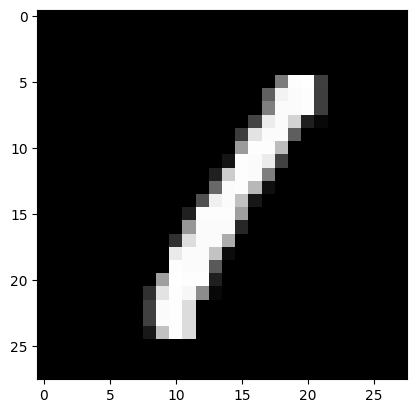

In [25]:
print(f"Number of MNIST training examples: {len(mnist_train)}")
print(f"Number of MNIST test examples: {len(mnist_test)}")

print("")

print(f"mnist train has two piece of informantion: data and targets:")
print(f"    mnist train data shape: {mnist_train.data.shape}")
print(f"    mnist train targets shape: {mnist_train.targets.shape}")

print("")

image, label = mnist_train[3] # select a data entry
print(f"Default image shape: {image.shape}")
image = torch.squeeze(image) # remove the 1 shape entries
print(f"Squeezed image shape: {image.shape}")
plt.imshow(image, cmap="gray")

print(f"The label for this image: {label}")

## Separating and shuffling the data

In [121]:
image_shape = image.shape
image_n_features = image_shape[0] * image_shape[1]
image_n_labels = len(mnist_train.classes)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

In [122]:
data_train_iter = iter(train_loader)
images, labels = next(data_train_iter)

print("Shape of the minibatch of images: {}".format(images.shape))
print("Shape of the minibatch of labels: {}".format(labels.shape))

Shape of the minibatch of images: torch.Size([100, 1, 28, 28])
Shape of the minibatch of labels: torch.Size([100])


## Logistic Regression

In [123]:
x = images.view(-1, image_n_features)
print("The shape of input x: {}".format(x.shape))

The shape of input x: torch.Size([100, 784])


In [124]:
# Randomly initialize weights W
W = torch.randn(image_n_features, image_n_labels)/np.sqrt(image_n_features)
W.requires_grad_()

# Initialize bias b as 0s
b = torch.zeros(image_n_labels, requires_grad=True)

# Linear transformation with W and b
y = torch.matmul(x, W) + b

In [125]:
y.shape

torch.Size([100, 10])

In [127]:
# Option 2: Softmax to probabilities with torch.nn.functional
import torch.nn.functional as F
py = F.softmax(y, dim=1) # dim is the dimension in which the data of one example is aligned
print(f"example 0 with torch.nn.functional.softmax:")
print(f"values: {py[0]}")
print(f"sum: {sum(py[0])}")

example 0 with torch.nn.functional.softmax:
values: tensor([0.0908, 0.0881, 0.1339, 0.1291, 0.1200, 0.0662, 0.0496, 0.0879, 0.1457,
        0.0887], grad_fn=<SelectBackward0>)
sum: 1.0


In [128]:
cross_entropy = F.cross_entropy(y, labels)
print("cross entropy with torch.nn.functional.cross_entropy: {}".format(cross_entropy))

cross entropy with torch.nn.functional.cross_entropy: 2.32179594039917


In [129]:
optimizer = torch.optim.SGD([W,b], lr=0.1)

In [130]:
cross_entropy.backward()

In [133]:
optimizer.step()

In [136]:
print("b.grad before zero_grad(): {}".format(b.grad))
optimizer.zero_grad()
print("b.grad after zero_grad(): {}".format(b.grad))

b.grad before zero_grad(): tensor([ 0.0071,  0.0192,  0.0018,  0.0053,  0.0340,  0.0394, -0.0286, -0.0244,
        -0.0220, -0.0319])
b.grad after zero_grad(): None


In [137]:
# Iterate through train set minibatchs
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    # Forward pass
    x = images.view(-1, 28*28)
    y = torch.matmul(x, W) + b
    cross_entropy = F.cross_entropy(y, labels)
    # Backward pass
    cross_entropy.backward()
    optimizer.step()

  0%|          | 0/600 [00:00<?, ?it/s]

In [138]:
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = torch.matmul(x, W) + b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9010000228881836


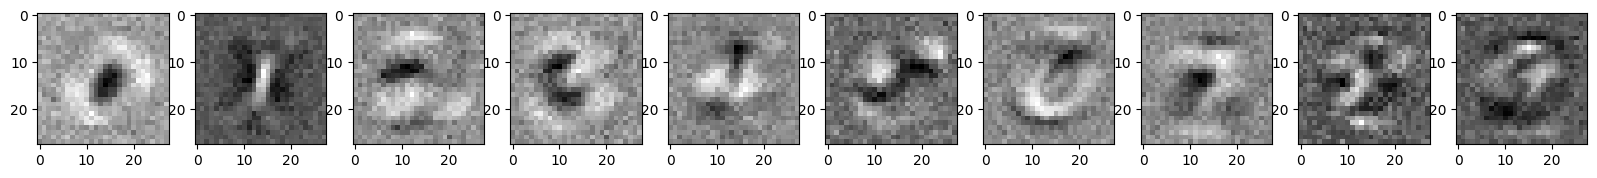

In [139]:
# Get weights
fig, ax = plt.subplots(1, 10, figsize=(20, 2))

for digit in range(10):
    ax[digit].imshow(W[:,digit].detach().view(28,28), cmap='gray')

In [140]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

class MNIST_Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, x):
        return self.lin(x)

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Instantiate model
model = MNIST_Logistic_Regression()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = model(x)
    loss = criterion(y, labels)
    # Backward pass
    loss.backward()
    optimizer.step()

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = model(x)
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9039000272750854
